In [411]:
import numpy as np
import ctypes as ct
import cv2
import sys
import argparse
from datasets import ViewDataSet3D
from completion import CompletionNet
import torch
from torchvision import datasets, transforms
from torch.autograd import Variable
import time
from numpy import cos, sin
import utils
import matplotlib.pyplot as plt
from PIL import Image
import os
import time
from multiprocessing import Pool, cpu_count
from scipy.signal import convolve2d
from scipy.interpolate import griddata
import scipy

%matplotlib inline
dll=np.ctypeslib.load_library('render_cuda_f','.')

In [412]:
def render(imgs, depths, pose, poses, tdepth):
    global fps
    t0 = time.time()
    showsz = imgs[0].shape[0]
    nimgs = len(imgs)
    show=np.zeros((nimgs, showsz,showsz * 2,3),dtype='uint8')
    target_depth = np.zeros((showsz,showsz * 2)).astype(np.uint32)
    target_depth[:] = (tdepth[:,:,0] * 12800).astype(np.int32)
    
    for i in range(len(imgs)):

        pose_after = pose.dot(np.linalg.inv(poses[0])).dot(poses[i]).astype(np.float32)
        #print('after',pose_after)

        dll.render(ct.c_int(imgs[i].shape[0]),
                   ct.c_int(imgs[i].shape[1]),
                   imgs[i].ctypes.data_as(ct.c_void_p),
                   depths[i].ctypes.data_as(ct.c_void_p),
                   pose_after.ctypes.data_as(ct.c_void_p),
                   show[i].ctypes.data_as(ct.c_void_p),
                   target_depth.ctypes.data_as(ct.c_void_p)
                  )
        
    return show, target_depth


In [413]:
def generate_data(args):
   
    idx  = args[0]
    print(idx)
    d    = args[1]
    #outf = args[2]
    print(idx)
    data = d[idx]   ## This operation stalls 95% of the time, CPU heavy
    sources = data[0]
    target = data[1]
    source_depths = data[2]
    target_depth = data[3]
    poses = [item.numpy() for item in data[-1]]
    show, _ =  render(sources, source_depths, poses[0], poses, target_depth)
    #np.savez(file = "%s/data_%d.npz" % (outf, idx), source = show, depth = depth, target = target)
    
    return show, target_depth, target

In [414]:
parser = argparse.ArgumentParser()
parser.add_argument('--debug'  , action='store_true', help='debug mode')
parser.add_argument('--dataroot'  , required = True, help='dataset path')
parser.add_argument('--outf'  , type = str, default = '', help='path of output folder')
opt = parser.parse_args(['--dataroot', '/home/fei/Downloads/highres_tiny', '--outf', '.'])
d = ViewDataSet3D(root=opt.dataroot, transform = np.array, mist_transform = np.array, seqlen = 5, off_3d = False)

Processing the data:
highres_tiny_fofn1.pkl
Total 10 scenes 9 train 1 test


In [687]:
idx = 345
show, depth, target = generate_data([idx, d])

345
345
source_pose 0 [[ -6.32085383e-01  -7.74877310e-01   5.76472329e-03  -5.69076681e+00]
 [ -7.74892628e-01   6.32033467e-01  -8.66599474e-03  -9.70727980e-01]
 [ -3.07158451e-03   9.94469039e-03   9.99945819e-01   1.51117003e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]
target_pose [[ -8.24728131e-01   5.65510213e-01   4.65327082e-03  -6.16688585e+00]
 [  5.65511167e-01   8.24739695e-01  -1.23779685e-03  -8.33958030e-01]
 [  4.53772396e-03  -1.61063054e-03   9.99988437e-01   1.51213205e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]
/home/fei/Downloads/highres_tiny/1AM6pFdrCSs/pano/rgb/point_ff8c54f5eeb445219d6dccc54a4dc527_view_equirectangular_domain_rgb.png
source_pose 1 [[  7.24532902e-01   6.89158261e-01  -1.06281564e-02  -7.85571623e+00]
 [  6.89180315e-01  -7.24587083e-01  -2.01314106e-03  -8.17371011e-01]
 [  9.08839796e-03   5.86612895e-03   9.99941468e-01   1.49648297e+00]
 [  0.00000000e+00   0.00000000e+00   0.

In [688]:
Image.fromarray(target.astype(np.uint8)).save('target%d.png' % idx)

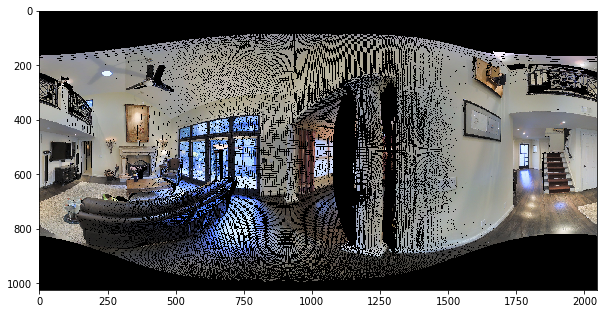

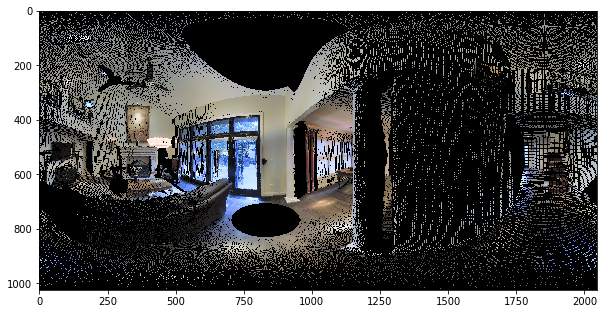

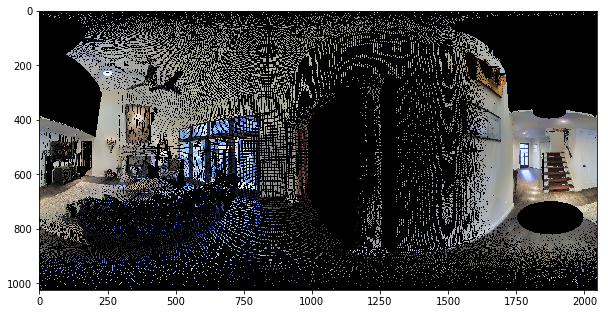

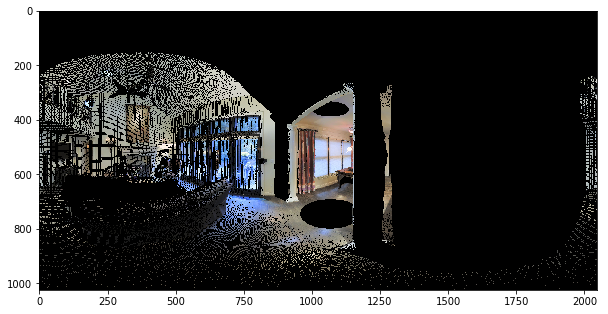

In [689]:
for i in range(4):
    plt.figure(figsize = (10,20))
    plt.imshow(show[i].astype(np.uint8))
    Image.fromarray(show[i].astype(np.uint8)).save('pc%d%d.png' % (idx, i))
    

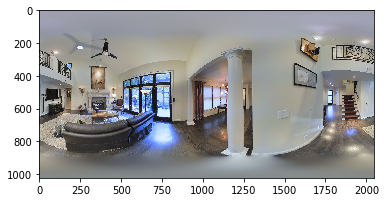

In [690]:
plt.imshow(target)
Image.fromarray(target.astype(np.uint8)).save('target.png')

In [691]:
mask = []
for i in range(len(show)):
    mask.append(np.sum(show[i], axis=2) > 0)

In [692]:
cmask = mask[0]

In [693]:
c0 = show[0][cmask]
c1 = target[cmask]
#sel = np.sum(c0, 1) > 300

In [694]:
c1.shape

(1208578, 3)

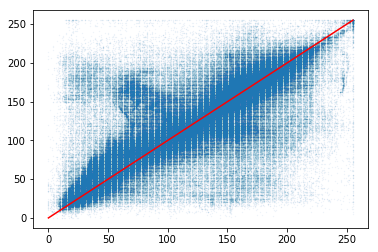

In [695]:
plt.scatter(c0[:,0], c1[:,0], 0.1, alpha = 0.1)
plt.plot([0,255], [0, 255], 'r')

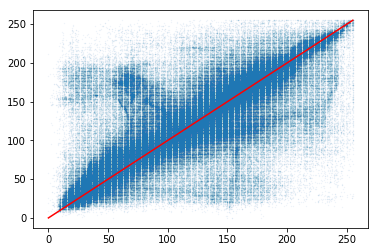

In [696]:
plt.scatter(c0[:,1], c1[:,1], 0.1, alpha = 0.1)
plt.plot([0,255], [0, 255], 'r')

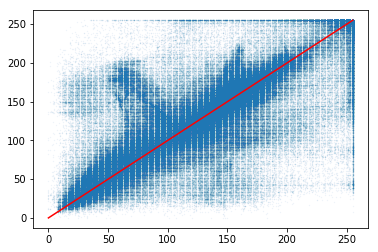

In [ ]:
plt.scatter(c0[:,2], c1[:,2], 0.1, alpha = 0.1)
plt.plot([0,255], [0, 255], 'r')

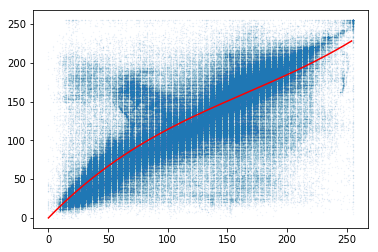

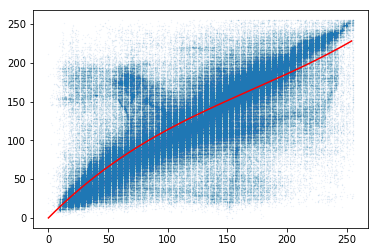

In [ ]:
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
models = []
for i in range(3):  
    model = make_pipeline(PolynomialFeatures(3, include_bias=False), LinearRegression(fit_intercept=False))
    model.fit(c0[:,i].reshape(-1,1), c1[:,i].reshape(-1,1))
    c1_pred = model.predict(np.arange(0,255,1).reshape(-1, 1))
    plt.figure()
    plt.scatter(c0[:,i], c1[:,i], 0.1, alpha = 0.1)
    plt.plot(np.arange(0,255,1), c1_pred, 'r')
    models.append(model)

In [ ]:
color_synced = np.zeros((1024,2048,3))
for i in range(3):
    color_synced[:,:,i] = np.clip(models[i].predict(show[0][:,:,i].reshape(1024 * 2048, 1)).reshape(1024,2048), 0, 255)

color_synced[:,:,0][np.logical_not(cmask)] = 0
color_synced[:,:,1][np.logical_not(cmask)] = 0
color_synced[:,:,2][np.logical_not(cmask)] = 0

plt.imshow(color_synced.astype(np.uint8))
Image.fromarray(color_synced.astype(np.uint8)).save('cc.png')

In [ ]:
target[cmask, :] = color_synced[cmask, :]
Image.fromarray(target.astype(np.uint8)).save('blend_after_interp.png')

In [ ]:
target[cmask, :] = show[0][cmask, :]
Image.fromarray(target.astype(np.uint8)).save('blend_before_interp.png')